# MinHashing

In [300]:
import os
import mmh3
import numpy as np
import collections
import pandas as pd
from datasketch import MinHash, MinHashLSH
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import LdaMulticore, LdaModel
from gensim import matutils as genmath, corpora, models
from itertools import tee
import pickle

DATA_SIZE=50000

### Utilities

In [301]:
#################### Utilities ######################
#hashes a list of strings
def listhash(l,seed):
	val = 0
	for e in l:
		val = val ^ mmh3.hash(e, seed)
	return val 

''' Extension of standard pairwise function to 3-pairwise from the py standard lib'''
def three_pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    # three_pairwise('ABCDEFG') --> ABC BCD CDE DEF EFG FG
    a, b, c = tee(iterable, 3) ## Create three iterators
    next(b, None) ## Advance the second
    next(c, None) ## Advance the third
    next(c, None) ## Advance the third once again. This ensures the third iterator starts at the third element and that we can create the 3-tuple
    return zip(a, b, c) ### Zip everything (1 elem, 2 elem, and 3 elem) concurrently.

''' Tokenize data and clean using NLTK package'''
stop = set(stopwords.words('english'))
def clean(text):

    tokens = word_tokenize(text)
    # Remove the punctuations, lower tokens and remove stopword
    tokens = [word.lower() for word in tokens if word not in stop and len(word) > 2]
   
    return tokens

def stored_pickled_pairs(pairs, filename):
    with open(f"{filename}.pickle", "wb") as handle:
        pickle.dump(pairs, handle, pickle.HIGHEST_PROTOCOL)

### Data preprocessing

In [302]:
''' Load DATA_SIZE amount of data/news articles'''
ROOT_DIR = os.path.abspath(os.curdir)
data = pd.read_csv(ROOT_DIR+"\\data\\articles1.csv")
data_content = data[:DATA_SIZE]["content"] #we are only interested in the content in each news

In [303]:
''' Clean data '''
cleaned_docs=[clean(data) for data in data_content]

''' Create 3-pair shingles'''
def shingle_docs(doc, k=1000):
    
    three_tup=list(three_pairwise(doc))
    three_tup=[elem for elem in three_tup if len(elem)==3]
    return three_tup

''' Listhash a doc, represented by a list of shingles (3-wise) '''
def hash_doc(doc):
    seed=1
    return np.array(sorted([listhash(shingle, seed) for shingle in doc]))

''' Shingle the entire dataset '''
shingled_docs = list(map(shingle_docs, cleaned_docs))

## Minhashing own implementation

In [304]:
# test_docs=list(zip(["You and me, we made a vow. For better or for worse. I can't believe you let me down",
# "Time, space and state. Equal everything explanable.",
# "You and me, we made a vow. For better or for worse. I can't believe you let me down"]))
seed=1
hashed_shingles=list(map(hash_doc, shingled_docs))
# hashed_shingles=np.array(sorted([listhash(shingle, seed) for shingle in shingled_docs]))
print(len(hashed_shingles))
hashed_shingles=[lst for lst in hashed_shingles if len(lst)>100]
# hashed_shingles
sig_m=np.array(hashed_shingles) #5000x100 -> 100x5000
print(sig_m.shape)

50000
(43985,)


C:\Users\hasee\AppData\Local\Temp\ipykernel_18236\4217812439.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_m=np.array(hashed_shingles) #5000x100 -> 100x5000


In [305]:
lens=min([len(x) for x in sig_m])
print(lens)
num_docs=sig_m.shape[0]
for i in range(num_docs):
    sig_m[i]=sig_m[i][:lens]
sig_m=np.stack(sig_m).T
sig_m.shape

101


(101, 43985)

### LSH implementation

In [306]:
''' Jaccard similarity'''
def jaccard(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

''' Implementation of LSH, dividing signature matrix into b band with r rows each'''
def LSH(sig_m, b, r):
    b=20
    r=5
    #b*r=num_hash_funcs

    sim_hashes=[]
    start=0
    for i in range(b):
        sim_hashes.append([listhash(col, seed=i) for col in sig_m[start:start+r,:].T])
        start=i+r

    return sim_hashes

''' Find candidate pairs by checking to see if the hashes match.
Then we check to see that the Jaccard similarity b/w each pair of docs is atleast t. If so, we consider it a candidate pair otherwise not '''
def get_cand_pairs(sim_hashes, t):
    cand_pairs=set()
    for L in sim_hashes:
        dups = collections.defaultdict(list)
        for i, e in enumerate(L):
            dups[e].append(i)
        for _, v in sorted(dups.items()):
            if len(v) >= 2:
                cand_pairs.add(tuple(v))
    cand_pairs=list(cand_pairs)
    filtered_cand_pairs = [pair for pair in cand_pairs if (jaccard(set(sig_m[:, pair[0]]), set(sig_m[:, pair[1]])) > t)]
    return filtered_cand_pairs
   

In [307]:
b=20
r=5
sim_hashes = LSH(sig_m, b=20, r=5)
pairs1=get_cand_pairs(sim_hashes, t=(1/b)**(1/r)) ## threshold = 0.549
len(pairs1)

36

In [308]:
print(sig_m.shape)
# print(pairs1)
stored_pickled_pairs(pairs1, "pairs1")

(101, 43985)


## Minhashing using package

In [309]:
'''num_perm is the number of permutations we want for the MinHash algorithm ,the higher the permutations the longer the runtime.
   min_dict1 maps each documents with the form of shingles to min hash signatures. We loop through all the set representations of 
   questions and calculate the signatures and store them in the min_dict1 dictionary'''
num_perm = 100
min_dict1 = {}
count3 = 1
for val in tqdm(shingled_docs):
    m = MinHash(num_perm=num_perm)
    for shingle in val:    
      a= []
      for i in shingle:
        i.encode('utf8')
        a.append(i)
      data1 = str(['_'.join(a)])

      m.update(data1.encode('utf8'))
    min_dict1["m{}".format(count3)] = m
    count3+=1

100%|██████████| 50000/50000 [06:31<00:00, 127.71it/s] 


In [310]:
'''We set the Jaccard similarity threshold as a parameter in MinHashLSH. We loop through the signatures or keys 
   in the min_dict dictionary ,Datasketch stores these in a dictionary format, where the key is a document
   and the value is other documents deemed similar based on the threshold. '''        
lsh = MinHashLSH(threshold=0.549, num_perm=num_perm)
for key in tqdm(min_dict1.keys()):
    lsh.insert(key,min_dict1[key]) # insert minhash data structure

100%|██████████| 50000/50000 [02:53<00:00, 287.91it/s] 


In [311]:
''' This function works with the dictionary output of the LSH to to output candidate pairs. '''
def create_cand_pairs():
    big_list = []
    for query in min_dict1.keys():
        bucket = lsh.query(min_dict1[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

 We found that there are so many repetitive pairs so that we have to remove those repetitive pairs

In [312]:
cand_pairs = create_cand_pairs() #Create candidate pairs.
pairs2 = [i for i in cand_pairs if i[1] != 'None'] #Remove pairs contain "None".

#Create set to store unique candidate pairs.
pair_set = set()
for pair in pairs2:
    pair_set.add(tuple(pair))

candidate_pairs=list(pair_set)

In [313]:
print(len(candidate_pairs))
stored_pickled_pairs(candidate_pairs, "pairs2")

325


# Topic Modeling

In [332]:
''' Load the stored pairs '''
with open("pairs2.pickle", "rb") as handle:
    loaded_pairs = pickle.load(handle)

In [358]:
''' flatten the list of tuples to get a single list containing the index of each plagiarised news article '''
from itertools import chain

lst_plag_news = list(chain.from_iterable(loaded_pairs))
lst_plag_news = [item[1:] for item in lst_plag_news] ## remove "m" symbol to make indexing easier later
lst_plag_news = list(set(lst_plag_news)) ## remove duplicates
print(len(lst_plag_news))

In [361]:
''' Extract documents indexed by elements from lst_plag_news '''
extraced_docs = [cleaned_docs[int(index)] for index in lst_plag_news]

In [364]:
''' Create a BoW representation of the extracted_docs '''
dictionary = corpora.Dictionary()
BoW_corpus = [
   dictionary.doc2bow(doc, allow_update=True) for doc in extraced_docs
]

In [365]:
''' Apply the LDA algorithm '''
lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=10)

In [366]:
#Calculate the topic probality for each document
topic_prob =lda_model.get_document_topics(BoW_corpus) 

In [380]:
topic_prob[0]

In [368]:
#Create a dic to store the topic for each dicument, we take the topic with the biggest probability as the topic of that document.
topic_document = {}
for i in enumerate(topic_prob):
    max = 0
    for j in i[1]:
        if j[1] > max:
            max = j[1]
            topic_document[i[0]] = j[0]

topic_num = []
for k,v in topic_document.items():
    topic_num.append(v)

In [372]:
from collections import Counter
topic_counter = Counter(topic_num)
print(topic_counter.most_common())

In [374]:
topic_num_list = []
for i in range(10):
    topic_num_list.append(topic_counter[i])

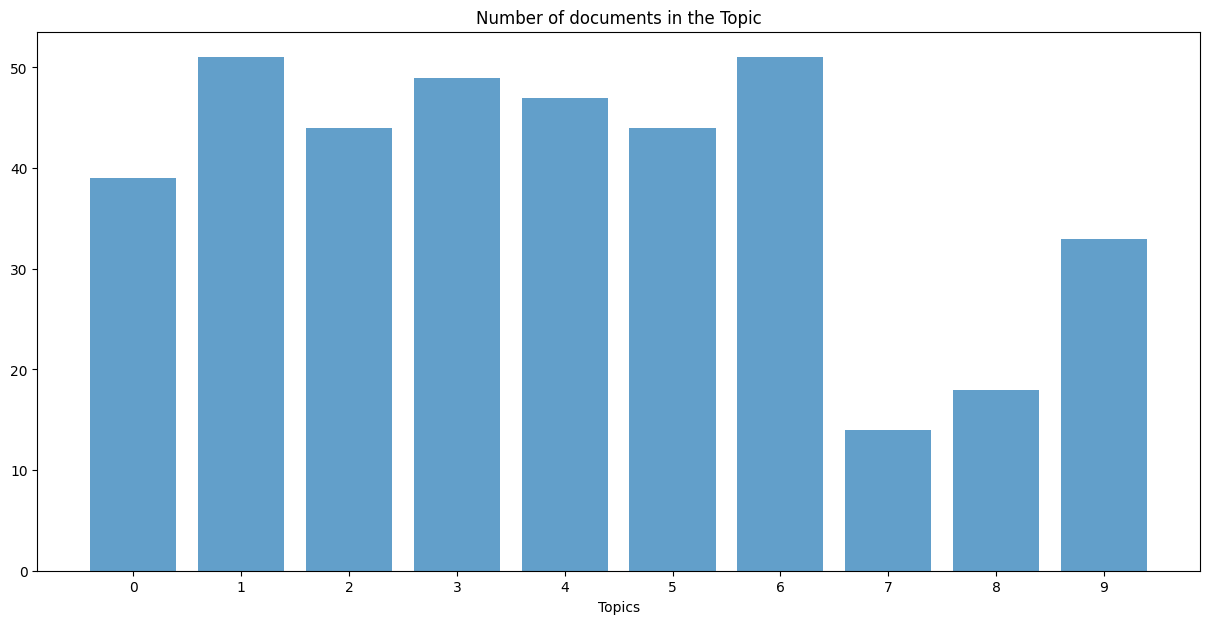

In [377]:
# coding=utf-8
from matplotlib import pyplot as plt
from matplotlib import font_manager
 
plt.figure(figsize=(15,7)) 
plt.bar(range(10),topic_num_list,align='center', alpha=0.7, ecolor='black', capsize=10)
plt.xticks(range(10),range(10))
plt.xlabel("Topics")
plt.title('Number of documents in the Topic')
plt.show()